In [3]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from medseg.common_utils.basic_operations import load_img_label_from_path,crop_or_pad,rescale_intensity
from medseg.models.model_util import makeVariable
from medseg.models.advanced_triplet_recon_segmentation_model import AdvancedTripletReconSegmentationModel
from medseg.common_utils.vis import plot_image,plot_general

# 1. Load data


load image: (10, 192, 192), label: (10, 192, 192)


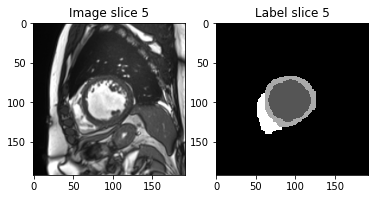

In [4]:
image_path = '../data/tiny_dataset/ED/001_img.nrrd'
label_path = '../data/tiny_dataset/ED/001_seg.nrrd'

def load_and_preprocess_image(image_path, label_path,image_size = (192,192)):
    image, label, sitkimg,sitklabel = load_img_label_from_path(image_path,label_path)
    image,label, _,_,_,_ = crop_or_pad(image=image, label=label,crop_size=image_size)
    print(f'load image: {image.shape}, label: {label.shape}')
    return image,label,sitkimg,sitklabel

image_size = (192,192)
image,label,sitkimg,sitklabel = load_and_preprocess_image(image_path,label_path,image_size)
slice_id = 5
plt.subplot(121)
plt.title(f'Image slice {slice_id}')
plt.imshow(image[slice_id],cmap='gray')
plt.subplot(122)
plt.title(f'Label slice {slice_id}')
plt.imshow(label[slice_id],cmap='gray',interpolation='nearest')


# 2. Load saved models (fast thinking network + slow thinking network)

In [5]:
## here we load the model trained w/ standard training
checkpoint_dir = '../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints'
segmentation_model = AdvancedTripletReconSegmentationModel(network_type = 'FCN_16_standard',
                                                         image_size=image_size[0],
                                                          checkpoint_dir=checkpoint_dir,
                                                          num_classes=4,use_gpu=True,debug=False)


segmentation_model.eval()

construct FCN_16_standard
load saved params from ../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints/image_encoder.pth
load saved params from ../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints/shape_decoder.pth
load saved params from ../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints/shape_encoder.pth
load saved params from ../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints/segmentation_decoder.pth
load saved params from ../saved/train_ACDC_10_n_cls_4/standard_training/0/model/best/checkpoints/image_decoder.pth
set optimizer for: image_encoder
set optimizer for: segmentation_decoder
set optimizer for: shape_encoder
set optimizer for: shape_decoder
set optimizer for: image_decoder


# 3. Extract latent image content code z_i and shape code z_s

In [6]:
torch.cuda.empty_cache()
imageV = makeVariable(torch.from_numpy(image[:,np.newaxis,:,:]),type='float',requires_grad=False,use_gpu=True)
labelV = makeVariable(torch.from_numpy(label),type='long',requires_grad=False,use_gpu=True)

segmentation_model.eval()
(z_i,z_s), initial_predict = segmentation_model.fast_predict(imageV)

# 4. Perform latent code maskings on latent image content code for corrupted image generation

In [7]:


def gen_corrupted_image(segmentation_model, latent_code, reference_image,method='channel', max_threshold=0.5,soft_masking=True,random_threshold=True,eval=False):
    assert max_threshold>=0 and max_threshold<=1, f'max_threshold {max_threshold} must be in [0,1]' 
    if max_threshold>0:
        perturbed_z_i_0,mask = segmentation_model.perturb_latent_code(latent_code =latent_code,
                                                                    label_y=reference_image,perturb_type=method,
                                                                    decoder_function = segmentation_model.model['image_decoder'],
                                                                    loss_type= 'mse',
                                                                    if_soft=soft_masking,
                                                                    threshold=max_threshold,random_threshold=random_threshold,if_detach=True)
        perturbed_image_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                    latent_code = perturbed_z_i_0,eval=eval,disable_track_bn_stats=True)
    else:
        perturbed_image_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                latent_code = latent_code,eval=eval,disable_track_bn_stats=True)
        mask = torch.ones_like(latent_code,device=latent_code.device, dtype = latent_code.dtype,requires_grad=False)
        perturbed_z_i_0 = latent_code
    return perturbed_image_0, perturbed_z_i_0,mask

## Note: here, we use a fixed threhold each time for ease of comparison
thresholds =[0, 0.1,0.2,0.3,0.4,0.5]
random_threshold = False
methods = ['dropout','channel','spatial'] ## 'channel', 'spatial' are targeted masking methods.
soft_masking = True ## for targeted masking.
results = {}

for i, method in enumerate(methods):
    results[method] ={}
    for j,threshold in enumerate(thresholds):
        corrupted_img, masked_z, mask = gen_corrupted_image(segmentation_model,latent_code=z_i,reference_image=imageV,
                                                method=method,soft_masking=soft_masking,max_threshold=threshold, random_threshold=random_threshold)
        results[method][threshold] = [corrupted_img, masked_z, mask]



# 5. Visualization: Generated challenging examples by different masking schemes

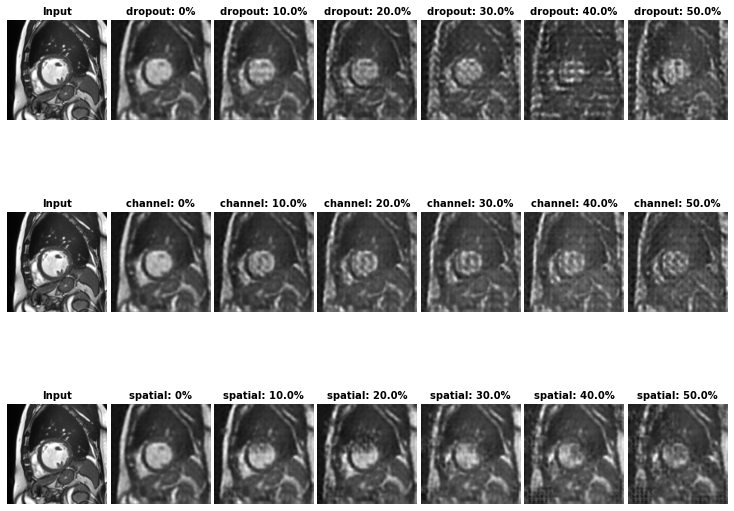

In [8]:
# visualization
fig,axes = plt.subplots(len(methods),1+len(thresholds),figsize=(10,8))
font_size = 10
slice_id =4
for i,method in enumerate(methods):
    plot_image(image[slice_id],ax = axes[i,0], title = 'Input',font_size=font_size)
    for j,threshold in enumerate(thresholds):
        result = results[method][threshold]
        subtitle = f'{method}: {threshold*100}%'
        plot_image(result[0].detach().cpu().numpy()[slice_id,0],ax = axes[i,j+1], title =subtitle,font_size=font_size)

# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.04, hspace=0)


# 6. Perform latent code maskings on latent shape code for corrupted segmentation generation

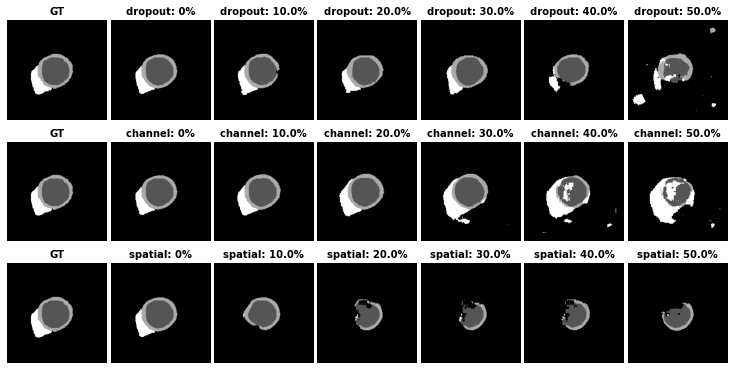

In [20]:
## corrupted shape
def gen_corrupted_segmentation(segmentation_model, latent_code, reference_segmentation,method='channel', max_threshold=0.5,soft_masking=True,random_threshold=True,eval=False):
    assert max_threshold>=0 and max_threshold<=1, f'max_threshold {max_threshold} must be in [0,1]' 
    if max_threshold>0:
        perturbed_z_s_0,mask = segmentation_model.perturb_latent_code(latent_code =latent_code,
                                                                    label_y=reference_segmentation,perturb_type=method,
                                                                    decoder_function = segmentation_model.model['segmentation_decoder'],
                                                                    loss_type= 'ce', 
                                                                    if_soft=soft_masking,
                                                                    threshold=max_threshold,random_threshold=random_threshold,
                                                                    ) 
        perturbed_segmentation_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['segmentation_decoder'],
                                                                    latent_code = perturbed_z_s_0,eval=eval,disable_track_bn_stats=True)
    else:
        perturbed_segmentation_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['segmentation_decoder'],
                                                                latent_code = latent_code,eval=eval,disable_track_bn_stats=True)
        mask = torch.ones_like(latent_code,device=latent_code.device, dtype = latent_code.dtype,requires_grad=False)
        perturbed_z_s_0 = latent_code
    return perturbed_segmentation_0, perturbed_z_s_0,mask

## Note: here, we use a fixed threhold each time for ease of comparison
thresholds =[0, 0.1,0.2,0.3,0.4,0.5]
methods = ['dropout','channel','spatial'] ## 'channel', 'spatial' are targeted masking methods.
soft_masking = True ## for targeted masking.
results = {}

for i, method in enumerate(methods):
    results[method] ={}
    for j,threshold in enumerate(thresholds):
        corrupted_seg, masked_z, mask = gen_corrupted_segmentation(segmentation_model,latent_code=z_s,reference_segmentation=labelV,
                                                method=method,soft_masking=soft_masking,max_threshold=threshold, random_threshold=random_threshold)
        results[method][threshold] = [corrupted_seg.max(1)[1], masked_z, mask]
# visualization
fig,axes = plt.subplots(len(methods),1+len(thresholds),figsize=(10,5))
font_size = 10
slice_id =4
for i,method in enumerate(methods):
    plot_general(label[slice_id],ax =axes[i,0], title = 'GT',font_size=font_size,cmap ='gray')
    for j,threshold in enumerate(thresholds):
        result = results[method][threshold]
        subtitle = f'{method}: {threshold*100}%'
        plot_general(result[0].detach().cpu().numpy()[slice_id],ax = axes[i,j+1], title =subtitle,font_size=font_size)
# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.04, hspace=0.04)
